In [62]:
import os, glob, shutil, sys, copy, time, json
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, color, transform, exposure
from skimage.filters import threshold_mean
from skimage.measure import shannon_entropy
import imagej
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

In [63]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx8g"
warnings.filterwarnings('ignore')

In [3]:
config = {
    "pixel-size-bf-20x" : 0.248,
    "pixel-size-bf-4x" : 1.17,
    "pixel-size-shg" : 0.42,
    "camera-resolution" : (1392, 1040), # (width, height)
#    "camera-resolution" : (512, 512), # (width, height)
    "lsm-resolution-base" : (1024, 1024),  
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
#    "slide-size" : (4000, 2000), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
}

In [4]:
def generate_grid(config, mag='20x', mod='bf', box=None, overlap=50):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size
    if mod == 'shg':
        if mag == '20x':
            pixel_size = config["pixel-size-shg"]
        if mag == '4x':
            raise ValueError('Not supported magnification for LSM')
        field_w = config["lsm-resolution-base"][0] * pixel_size
        field_h = config["lsm-resolution-base"][1] * pixel_size
    field_o = overlap * pixel_size
    grid_w = int(np.rint((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.rint((e_y - s_y) / (field_h - field_o)))
    xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            # check hard limit
            xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list, (grid_h, grid_w) # row, col

In [19]:
core.get_focus_device()

'Z'

In [18]:
core.wait_for_device(xy_device)

In [47]:
def whole_slide_scan(config, save_path, acq_name, position_list=None, grid=None, z_positions=None, mda=True, core=None):
    if mda == True:
        if z_positions is not None:
            position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            with Acquisition(save_path, acq_name) as acq:
                events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                acq.acquire(events)
        else:
            with Acquisition(save_path, acq_name) as acq:
                events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                acq.acquire(events)
    else:
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        if z_positions is not None:
            position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], position_list.shape[1], 3)
            for pos_row in range(position_list.shape[0]):
                for pos_col in range(position_list.shape[1]):
                    z_pos = position_list[pos_row, pos_col, 2]
                    x_pos = position_list[pos_row, pos_col, 0]
                    y_pos = position_list[pos_row, pos_col, 1]
                    if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                        or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                        or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                        print('position out of range')
                        break
                    core.set_focus_device('ZStage:Z:32')                
                    core.set_position(z_pos)
                    core.set_xy_position(x_pos, y_pos)
                    xy_device = core.get_xy_stage_device()
                    z_device = core.get_focus_device()
                    core.wait_for_device(xy_device)
                    core.wait_for_device(z_device)
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                    io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels)) 
        else:
            position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            for pos_row in range(position_list.shape[0]):
                for pos_col in range(position_list.shape[1]):
                    x_pos = position_list[pos_row, pos_col, 0]
                    y_pos = position_list[pos_row, pos_col, 1]
                    if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                        or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                        print('position out of range')
                        break
                    core.set_xy_position(x_pos, y_pos)
                    xy_device = core.get_xy_stage_device()
                    core.wait_for_device(xy_device)
                    pixels = snap_image(core, rgb=True, flip_channel=True)   
                    io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))                    
    #         with Acquisition(save_path, acq_name) as acq:
    #             pos_count = 0
    #             events = []
    #             for idx_x in range(position_list.shape[1]):
    #                 for idx_y in range(position_list.shape[0]):
    #                     evt = {
    #                         'axes' : {'position' : pos_count},
    #                         'x' : position_list[idx_y, idx_x, 0],
    #                         'y' : position_list[idx_y, idx_x, 1]
    #                     }
    #                     print(pos_count)
    #                     pos_count = pos_count + 1
    #                 events.append(evt)
    #             acq.acquire(events)
    #     if grid is not None:
    #         with Acquisition(save_path, acq_name, tile_overlap=100) as acq:
    #             for row in range(grid[0]):
    #                 for col in range(grid[1]):
    #                     acq.acquire({'row' : row, 'col' : col})

In [59]:
def stitching(config, ij, save_path, acq_name, mod='bf', mag='4x', mda=True, position_list=None, flip_x=False, flip_y=False):
    position_list_flat = position_list.reshape(-1, 2)
    stitch_folder = os.path.join('data/stitching/tiles', acq_name)
    os.makedirs(stitch_folder, exist_ok=True)
    out_folder = os.path.join('data/stitching/stitched', acq_name)
    os.makedirs(out_folder, exist_ok=True)
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
    else:
        pixel_size = config["pixel-size-shg"]
    if mda:
        data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
        dataset = Dataset(data_path)
    else:
        image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
    with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
        print('dim = {}'.format(2), file=text_file)
        for pos_row in range(position_list.shape[0]):
            for pos_col in range(position_list.shape[1]):
                x = int(position_list[pos_row, pos_col, 0] / pixel_size)
                y = int(position_list[pos_row, pos_col, 1] / pixel_size)
                print('{}_{}.tiff; ; ({}, {})'.format(pos_row, pos_col, x, y), file=text_file)
                if mda:
                    img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
                else:
                    img = io.imread(image_list[pos_row*position_list.shape[1]+pos_col])
                if flip_y:
                    img = img[::-1, :]
                if flip_x:
                    img = img[:, ::-1]
                if mda:
                    io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
                else:
                    s
    sys.stdout.write('stitching, please wait...')
    temp_channel_folder = 'data/stitching/channel_temp'
    os.makedirs(temp_channel_folder, exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
            'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
            'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
            'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
            'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
            'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)
    if mod == 'bf':
        list_channels = [f for f in os.listdir(temp_channel_folder)]
        if len(list_channels) == 1:
            c1 = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
            io.imsave(os.path.join(out_folder, 'fused.tiff'), img_as_ubyte(c1))
        else:
            c1 = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
            c2 = io.imread(os.path.join(temp_channel_folder, list_channels[1]))
            c3 = io.imread(os.path.join(temp_channel_folder, list_channels[2]))
            img_to_save = np.stack((c1, c2, c3)).transpose((1, 2, 0))
            io.imsave(os.path.join(out_folder, 'fused.tiff'), img_as_ubyte(img_to_save))
    shutil.rmtree(temp_channel_folder)

In [37]:
def bounding_image(config, image):
        img_g = color.rgb2gray(img)
        img_t = transform.rescale(img_g, 0.1, anti_aliasing=None, order=0)
        thresh = threshold_mean(img_t)
        img_d = 1 - (img_t > thresh)
        imgh = np.sum(img_d, axis = 1)
        imgw = np.sum(img_d, axis = 0)
        imgh_m = np.mean(imgh)
        imgw_m = np.mean(imgw)
        box_s_x = min(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_s_y = min(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        box_e_x = max(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_e_y = max(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        start = config["slide-start"]
        low_box_bounded = (config["slide-start"][0] + config["pixel-size-bf-4x"] * box_s_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_s_y,
                           config["slide-start"][0] + config["pixel-size-bf-4x"] * box_e_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_e_y,
                          )
        fig, ax = plt.subplots(1)
        ax.imshow(img_t, cmap='gray')
        rect = patches.Rectangle((int(box_s_x/10),int(box_s_y/10)), int((box_e_x-box_s_x)/10), int((box_e_y-box_s_y)/10), linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        return low_box_bounded # bounding box in real stage position

In [38]:
def switch_objective(mag='4x'): # brightfield
    if mag == '4x':
        core.set_property('Turret:O:35', 'Label', 'Position-2')
        core.set_focus_device('ZStage:F:32')
        core.set_position(0)
        time.sleep(1)
        core.set_focus_device('ZStage:Z:32')
        core.set_position(0)
        time.sleep(1)
        core.set_property('LED-Dev1ao0', 'Voltage', 5.0)
        # autofocus
    if mag == '20x':
        core.set_property('Turret:O:35', 'Label', 'Position-1')
        core.set_focus_device('ZStage:F:32')
        core.set_position(-16000)
        time.sleep(1)
        core.set_focus_device('ZStage:Z:32')
        core.set_position(-6850)
        time.sleep(1)
        core.set_property('LED-Dev1ao0', 'Voltage', 5.0)
        # autofocus      

In [39]:
def switch_mod(mod='shg'):
    current_objective = core.get_property('Turret:O:35', 'Label')
    if mod == 'shg':
        if current_objective == 'Position-2':
            raise ValueError('Not supported magnification for LSM')
        if current_objective == 'Position-1':
            print('set')
            ### set Camera, Z and F position
    if mod == 'bf':
        if current_objective == 'Position-2':
            switch_objective('4x')
        if current_objective == 'Position-1': 
            switch_objective('20x')            

In [40]:
def estimate_background(config, dataset, position_list):
    sum_img = np.zeros((config["camera-resolution"][0], config["camera-resolution"][1], 3))
    for pos_row in range(position_list.shape[0]):
        for pos_col in range(position_list.shape[1]):
            img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
            sum_img = np.array(img_as_float(img)) + sum_img
    return sum_img

def white_balance(img, bg, gain=0.8):
    img = img_as_float(img)
    bg = img_as_float(bg)
    r = np.mean(bg[:, :, 0])
    g = np.mean(bg[:, :, 1])
    b = np.mean(bg[:, :, 2])
    mm = max(r, g, b)
    img[:, :, 0] = np.clip(img[:, :, 0] * mm / r * gain, 0, 1)
    img[:, :, 1] = np.clip(img[:, :, 1] * mm / g * gain, 0, 1)
    img[:, :, 2] = np.clip(img[:, :, 2] * mm / b * gain, 0, 1)
    return img

def flat_field(img, bg, gain=1.25):
    img = img_as_float(img)
    bg = img_as_float(bg)
    r = np.mean(bg[:, :, 0])
    g = np.mean(bg[:, :, 1])
    b = np.mean(bg[:, :, 2])
    img[:, :, 0] = 0.95 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 0], bg[:, :, 0] + 0.00) * r * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    img[:, :, 1] = 0.95 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 1], bg[:, :, 1] + 0.00) * g * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    img[:, :, 2] = 0.95 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 2], bg[:, :, 2] + 0.00) * b * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    return img

In [41]:
def extract_rois(config, annotation_path, image_size, mag='4x'):
    rois = []
    with open(annotation_path) as json_file:
        instances = json.load(json_file)
        for instance in instances:
            roi = shape(instance)
            temp_x, temp_y = roi.exterior.coords.xy
            coords = np.stack((temp_x, temp_y)).transpose()[0:-1]
            for i in range(coords.shape[0]):
                x = image_size[0] - coords[i, 0]
                y = coords[i, 1]
                if mag == '4x':
                    x = x * config["pixel-size-bf-4x"]
                    y = y * config["pixel-size-bf-4x"]
                if mag == '20x':
                    x = x * config["pixel-size-bf-20x"]
                    y = y * config["pixel-size-bf-20x"]
                coords[i] = [x, y]
            rois.append((coords[3, 0], coords[3, 1], coords[1, 0], coords[1, 1]))
    return rois # (x_pos, y_pos)

In [12]:
annotation_path = filedialog.askopenfilename(filetypes=(("Json annotation files","*.json"),("All files","*.*")))
coords = extract_rois(config, 'example/qupath-pj/annotation results/BIC14011b.jpg.json', image_size=(22689, 15080))

FileNotFoundError: [Errno 2] No such file or directory: 'example/qupath-pj/annotation results/BIC14011b.jpg.json'

In [100]:
coords

[(20960.55, 1784.25, 22910.94, 3727.62),
 (16328.519999999999, 1836.8999999999999, 18083.52, 3960.45)]

In [12]:
bridge = Bridge()
core = bridge.get_core()

In [14]:
switch_objective('4x')

In [27]:
save_path = 'data/acquisition'
acq_name = 'slide-color-test'

In [28]:
position_list, grid = generate_grid(config, mag='4x')
position_list.shape

(16, 24, 2)

In [29]:
position_list

array([[[    0.  ,     0.  ],
        [ 1570.14,     0.  ],
        [ 3140.28,     0.  ],
        [ 4710.42,     0.  ],
        [ 6280.56,     0.  ],
        [ 7850.7 ,     0.  ],
        [ 9420.84,     0.  ],
        [10990.98,     0.  ],
        [12561.12,     0.  ],
        [14131.26,     0.  ],
        [15701.4 ,     0.  ],
        [17271.54,     0.  ],
        [18841.68,     0.  ],
        [20411.82,     0.  ],
        [21981.96,     0.  ],
        [23552.1 ,     0.  ],
        [25122.24,     0.  ],
        [26692.38,     0.  ],
        [28262.52,     0.  ],
        [29832.66,     0.  ],
        [31402.8 ,     0.  ],
        [32972.94,     0.  ],
        [34543.08,     0.  ],
        [36113.22,     0.  ]],

       [[    0.  ,  1158.3 ],
        [ 1570.14,  1158.3 ],
        [ 3140.28,  1158.3 ],
        [ 4710.42,  1158.3 ],
        [ 6280.56,  1158.3 ],
        [ 7850.7 ,  1158.3 ],
        [ 9420.84,  1158.3 ],
        [10990.98,  1158.3 ],
        [12561.12,  1158.3 ],
        

In [48]:
whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core)

<ipython-input-47-1566cf0e86fc>:51: UserWarning: data/acquisition\slide-color-test_13/0_0.tiff is a low contrast image
  io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))
<ipython-input-47-1566cf0e86fc>:51: UserWarning: data/acquisition\slide-color-test_13/0_1.tiff is a low contrast image
  io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))
<ipython-input-47-1566cf0e86fc>:51: UserWarning: data/acquisition\slide-color-test_13/0_2.tiff is a low contrast image
  io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))
<ipython-input-47-1566cf0e86fc>:51: UserWarning: data/acquisition\slide-color-test_13/0_3.tiff is a low contrast image
  io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))
<ipython-input-47-1566cf0e86fc>:51: UserWarning: data/acquisition\slide-color-test_13/0_4.tiff is a low contrast image
  io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte

In [36]:
data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
dataset = Dataset(data_path)
dataset.axes

Dataset opened of 1


{'position': {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,

In [37]:
img = dataset.read_image(position=100)

In [38]:
img.shape

(1040, 1392, 3)

In [39]:
dask_array = dataset.as_array(stitched=True)

TypeError: 'NoneType' object is not subscriptable

In [51]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [60]:
Image.MAX_IMAGE_PIXELS = None  
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_x=True)

<ipython-input-59-5c765af52546>:34: UserWarning: data/stitching/tiles\slide-color-test/0_0.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-59-5c765af52546>:34: UserWarning: data/stitching/tiles\slide-color-test/0_1.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-59-5c765af52546>:34: UserWarning: data/stitching/tiles\slide-color-test/0_2.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-59-5c765af52546>:34: UserWarning: data/stitching/tiles\slide-color-test/0_3.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-59-5c765af52546>:34: UserWarning: data/stitching/tiles\slide-color-test/0_4.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (774 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (55 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-sca

In [26]:
Image.MAX_IMAGE_PIXELS = None        
img = io.imread('example/BIC14011b.jpg')

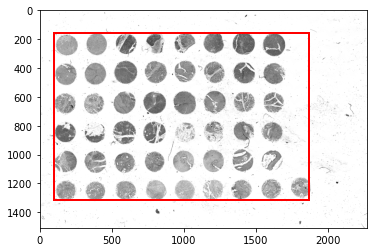

(2250.0, 3555.0, 42007.5, 29632.5)

In [67]:
bounding_box_4x = bounding_image(config, img)

In [111]:
position_list_20x, grid_20x = generate_grid(config, mag='20x')
position_list_20x.shape

(17, 22, 2)

In [83]:
# optimal 5085
core.set_position(4969)

In [84]:
core.get_position()

4969

In [85]:
autofocus(core, search_range=90)

4929
17.64436457496112
4939
17.65342005021535
4949
17.661655348030425
4959
17.668416834855833
4969
17.674633440854986
4979
17.67761608605648
4989
17.67937351747418
4999
17.67871046983665
72


4992.797468354431

In [43]:
def snap_image(core, rgb, flip_channel=True):
    core.snap_image()
    tagged_image = core.get_tagged_image()
    if rgb == True:
        pixels = np.reshape(
            tagged_image.pix,
            newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
            )
    else:
        pixels = np.reshape(
            tagged_image.pix,
            newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
            )
    pixels = pixels[:, :, 0:3]
    if flip_channel:
        pixels = np.flip(pixels, 2)
    return pixels

def autofocus(core, method='entropy', rgb=True, search_range=45, crop_ratio=1.0):
    current_z = core.get_position()
    interval_z = int(search_range/9)
    scores = []
    positions = []
    count = 0
    for step in range(-4, 4):
        position_z = step * interval_z + current_z
        if position_z < -3000.0 or position_z > 22000.0:
            break
        core.set_position(position_z)
        if count == 0:
            time.sleep(1.0)
        else:
            time.sleep(0.25)
        count = count + 1
        pixels = snap_image(core, rgb, True)
#         print(pixels.shape)
#         plt.figure(figsize=(8, 6))
#         imgplot = plt.imshow(exposure.rescale_intensity(pixels[:, :, 0:3], out_range=(0, 1)))
#         plt.axis("off")
#         plt.show()
        img_gray = color.rgb2gray(color.rgba2rgb(pixels))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        print(position_z)
        print(score)
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions)
#     scores_array = scores_array/np.sum(scores_array)
#     mean, _ = norm.fit(scores_array)
    
    new_length = len(positions) * 10
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
#     print(new_y)
    idx = np.argmax(new_y)
    print(idx)
    focus_z = new_x[idx]
#     print(focus_z)
    # check hard limit
    return focus_z

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        time.sleep(0.25)
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        time.sleep(0.25)
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    if resample_grid_size is not None:
        position_list_z = transform.resize(position_list_z, output_shape=resample_grid_size, order=3)
    return position_list_z

In [140]:
position_list.shape
position_list_20x.shape

(17, 22, 2)

In [141]:
position_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


In [145]:
position_list_z.shape

(17, 22)

In [152]:
position_list_20x.shape

(17, 22, 2)

In [153]:
whole_slide_scan(config, save_path, acq_name, position_list=position_list_20x, z_positions=position_list_z)

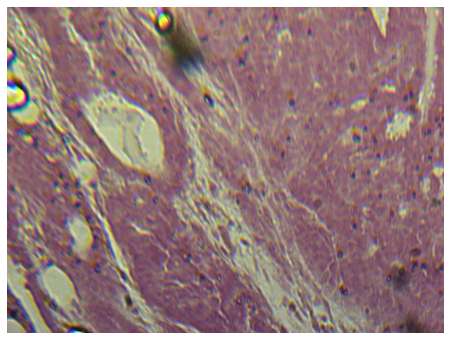

In [33]:
core.snap_image()
tagged_image = core.get_tagged_image()
rgb = True
if rgb == True:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
        )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
pixels = pixels[:, :, 0:3]
pixels=np.flip(pixels, 2)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [40]:
switch_objective('20x')

In [56]:
core.set_focus_device('ZStage:F:32')
core.set_position(-19000)
time.sleep(1)
core.set_focus_device('ZStage:Z:32')
core.set_position(-5150)
time.sleep(1)